## Four-class classification
I added **bacteria pneumonia** images and use ResNet50 to build a three-class classifier

## Acknowledgement

Most of the code here is based on [this notebook](https://www.kaggle.com/dabawse/covid-19-classification-with-resnet50) by Jeebz.

## 04-17
* Change into Train, Valid and Test as 6:2:2

## 04-11
* Augmentor
* Select images of bacteria from each patients

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
import random

import os
import itertools
import glob
import shutil

warnings.filterwarnings('ignore')

In [2]:
import torch.nn.functional as F

In [3]:
!pip install Augmentor


In [4]:
import Augmentor

In [5]:

files = glob.glob('/kaggle/working/*/*/*.png')
for f in files:
    os.remove(f)

## Data Preprossessing

In [6]:
# ## count the number of bacteria
# num_bacteria = 0
# for phase in ['train', 'test', 'val']:
#     for i in os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/' + phase + '/PNEUMONIA/'):
#         if i.split('_')[1] == 'bacteria':
#             num_bacteria+=1
# print('number of bacteria images: ', num_bacteria)



### Image visualization

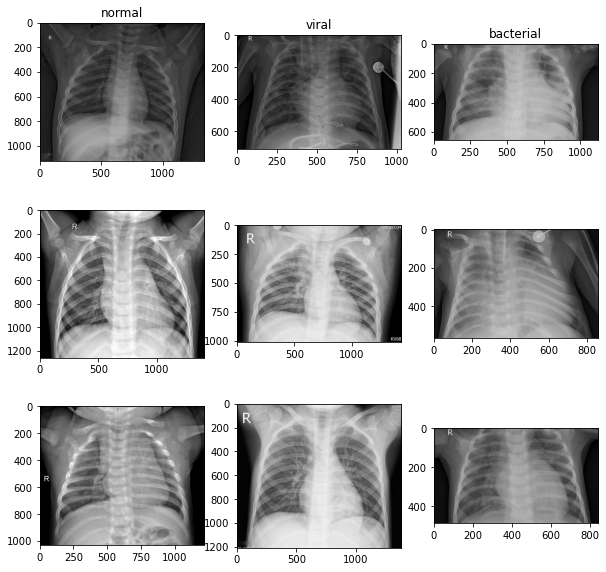

In [7]:
## check the images in the chest x ray data set
normal_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes[0][0].imshow(cv2.imread(normal_path + os.listdir(normal_path)[0]))
axes[0][0].set_title('normal')
axes[1][0].imshow(cv2.imread(normal_path + os.listdir(normal_path)[1]))
axes[2][0].imshow(cv2.imread(normal_path + os.listdir(normal_path)[2]))

axes[0][1].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[0]))
axes[0][1].set_title('viral')
axes[1][1].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[1]))
axes[2][1].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[2]))

axes[0][2].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[5]))
axes[0][2].set_title('bacterial')
axes[1][2].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[8]))
axes[2][2].imshow(cv2.imread(pneu_path + os.listdir(pneu_path)[9]))

In [8]:
## check images in the COVID radiography dataset
covid_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/'
normal_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/'
viral_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/'

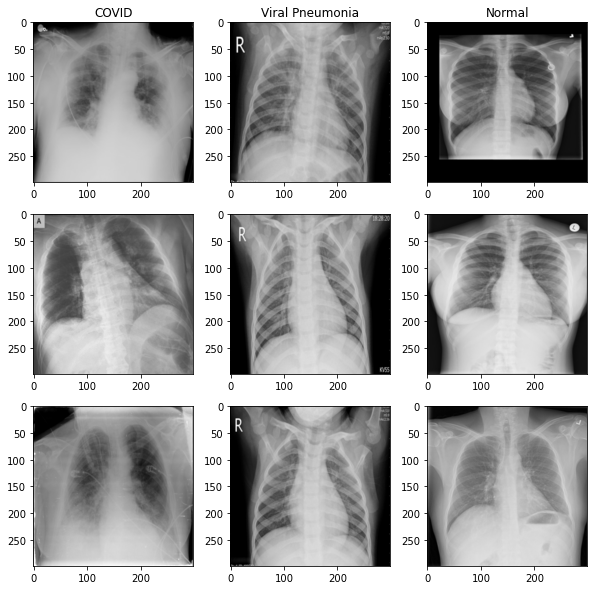

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
labels = ['Covid', 'Normal', 'Pneumonia']
axes[0][0].imshow(cv2.imread(covid_path + 'COVID-1.png'))
axes[0][0].set_title('COVID')
axes[1][0].imshow(cv2.imread(covid_path + 'COVID-2.png'))
axes[2][0].imshow(cv2.imread(covid_path + 'COVID-3.png'))

axes[0][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-1.png'))
axes[0][1].set_title('Viral Pneumonia')
axes[1][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-2.png'))
axes[2][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-3.png'))

axes[0][2].imshow(cv2.imread(normal_path+'Normal-1.png'))
axes[0][2].set_title('Normal')
axes[1][2].imshow(cv2.imread(normal_path+'Normal-2.png'))
axes[2][2].imshow(cv2.imread(normal_path+'Normal-3.png'));


### Organize Data into Train, Valid and Test

In [10]:
## making directories
os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/test')
os.mkdir('/kaggle/working/valid')

os.mkdir('/kaggle/working/train/covid')
os.mkdir('/kaggle/working/test/covid')
os.mkdir('/kaggle/working/valid/covid')


os.mkdir('/kaggle/working/train/normal')
os.mkdir('/kaggle/working/test/normal')
os.mkdir('/kaggle/working/valid/normal')

os.mkdir('/kaggle/working/train/viral')
os.mkdir('/kaggle/working/test/viral')
os.mkdir('/kaggle/working/valid/viral')

os.mkdir('/kaggle/working/train/bacterial')
os.mkdir('/kaggle/working/test/bacterial')
os.mkdir('/kaggle/working/valid/bacterial')

In [11]:
## making directories for Augmentor 
## these files will be deleted in the end
os.mkdir('/kaggle/working/train_src')
os.mkdir('/kaggle/working/test_src')
os.mkdir('/kaggle/working/valid_src')


os.mkdir('/kaggle/working/train_src/covid')
os.mkdir('/kaggle/working/test_src/covid')
os.mkdir('/kaggle/working/valid_src/covid')

os.mkdir('/kaggle/working/train_src/normal')
os.mkdir('/kaggle/working/test_src/normal')
os.mkdir('/kaggle/working/valid_src/normal')

os.mkdir('/kaggle/working/train_src/viral')
os.mkdir('/kaggle/working/test_src/viral')
os.mkdir('/kaggle/working/valid_src/viral')

os.mkdir('/kaggle/working/train_src/bacterial')
os.mkdir('/kaggle/working/test_src/bacterial')
os.mkdir('/kaggle/working/valid_src/bacterial')

In [12]:
# os.mkdir('/kaggle/working/valid_src')
# os.mkdir('/kaggle/working/valid_src/covid')
# os.mkdir('/kaggle/working/valid_src/normal')
# os.mkdir('/kaggle/working/valid_src/viral')
# os.mkdir('/kaggle/working/valid_src/bacterial')

In [13]:
## move bacteria to one folder
os.mkdir('/kaggle/working/bacteria_merge/')

In [14]:
## copy model to the required directory for bacteria images
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':

        shutil.copy(img, '/kaggle/working/bacteria_merge/')
        
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':
        #print(img.split('/')[-1].split('_')[1])

        shutil.copy(img, '/kaggle/working/bacteria_merge/')
        
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':
        #print(img.split('/')[-1].split('_')[1])

        shutil.copy(img, '/kaggle/working/bacteria_merge/')

In [15]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

2780

In [16]:
patient_list = [int(i.split("_")[0][6:]) for i in os.listdir('/kaggle/working/bacteria_merge/')]

In [17]:
len(np.unique(patient_list)), len(patient_list)

(1437, 2780)

In [18]:
selected_list = []
for p in np.unique(patient_list):
    matched_files = [i for i in os.listdir('/kaggle/working/bacteria_merge/') if int(i.split("_")[0][6:])==p]
    if len(matched_files) ==1:
        selected_list.append('/kaggle/working/bacteria_merge/' + matched_files[0])
    else:
        #print('more')
        selected_file = random.choice(matched_files)
        #print(len(selected_file))
        selected_list.append('/kaggle/working/bacteria_merge/' + selected_file)
## delete unnecessary file


In [19]:
files = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')
for f in files:
    #print(f)
    if f not in selected_list:
        os.remove(f)

In [20]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

1437

In [21]:
## convert to jpg
jpgs = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')

for j in jpgs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-4] + 'png', img)
## remove jpeg
files = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')
for f in files:
    os.remove(f)
len(os.listdir('/kaggle/working/bacteria_merge/'))

1437

In [22]:
bacterial_path = '/kaggle/working/bacteria_merge/'

In [23]:
## decide length for each set
covid_train_len = int(np.floor(len(os.listdir(covid_path))*0.5))
covid_len = len(os.listdir(covid_path))

normal_train_len = int(np.floor(len(os.listdir(normal_path))*0.5))
normal_len = len(os.listdir(normal_path))

viral_train_len = int(np.floor(len(os.listdir(viral_path))*0.5))
viral_len = len(os.listdir(viral_path))

bacterial_train_len = int(np.floor(len(os.listdir(bacterial_path))*.5))
bacterial_len = len(os.listdir(bacterial_path))
print('COVID dataset length: ', covid_len, ' Normal dataset length: ', normal_len, ' Viral dataset length: ', viral_len, \
     'bacterial dataste length', bacterial_len)

COVID dataset length:  3616  Normal dataset length:  10192  Viral dataset length:  1345 bacterial dataste length 1437


In [24]:
os.listdir('/kaggle/working/train/')

['covid', 'bacterial', 'viral', 'normal']

In [25]:
## move a certain set of image to test first

In [26]:
random.seed(88)

In [27]:
for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(viral_path, '*.png')), key=lambda k: random.random()), viral_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/viral')

for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(covid_path, '*.png')),key=lambda k: random.random()), covid_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/covid')
    
for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(normal_path, '*.png')),key=lambda k: random.random()), normal_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/normal')

for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(bacterial_path, '*.png')),key=lambda k: random.random()), bacterial_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/bacterial/')
    
for testimg in itertools.islice(sorted(glob.iglob(os.path.join(covid_path, '*.png')),key=lambda k: random.random()), covid_train_len, covid_len):
    shutil.copy(testimg, '/kaggle/working/test_src/covid')

for testimg in itertools.islice(sorted(glob.iglob(os.path.join(normal_path, '*.png')),key=lambda k: random.random()), normal_train_len, normal_len):
    shutil.copy(testimg, '/kaggle/working/test_src/normal')

for testimg in itertools.islice(sorted(glob.iglob(os.path.join(viral_path, '*.png')), key=lambda k: random.random()),viral_train_len, viral_len):
    shutil.copy(testimg, '/kaggle/working/test_src/viral')
    
for testimg in itertools.islice(sorted(glob.iglob(os.path.join(bacterial_path, '*.png')),key=lambda k: random.random()),bacterial_train_len, bacterial_len):
    shutil.copy(testimg, '/kaggle/working/test_src/bacterial/')

In [28]:
random.seed(6)

In [29]:
for validimg in os.listdir('/kaggle/working/train_src/viral/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/viral/' + validimg, '/kaggle/working/valid_src/viral/')
        
for validimg in os.listdir('/kaggle/working/train_src/bacterial/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/bacterial/' + validimg, '/kaggle/working/valid_src/bacterial/')
        
for validimg in os.listdir('/kaggle/working/train_src/covid/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/covid/' + validimg, '/kaggle/working/valid_src/covid/')
        
for validimg in os.listdir('/kaggle/working/train_src/normal/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/normal/' + validimg, '/kaggle/working/valid_src/normal/')

In [30]:
len(os.listdir('/kaggle/working/train_src/viral/')), len(os.listdir('/kaggle/working/test_src/viral/')), len(os.listdir('/kaggle/working/valid_src/viral'))

(536, 673, 136)

In [31]:
len(os.listdir('/kaggle/working/train_src/bacterial/')), len(os.listdir('/kaggle/working/test_src/bacterial/')), len(os.listdir('/kaggle/working/valid_src/bacterial'))

(575, 719, 143)

In [32]:
len(os.listdir('/kaggle/working/train_src/normal/')), len(os.listdir('/kaggle/working/test_src/normal/')), len(os.listdir('/kaggle/working/valid_src/normal'))

(4065, 5096, 1031)

In [33]:
len(os.listdir('/kaggle/working/train_src/covid/')), len(os.listdir('/kaggle/working/test_src/covid/')), len(os.listdir('/kaggle/working/valid_src/covid'))

(1458, 1808, 350)

In [34]:
len(os.listdir('/kaggle/working/train_src/covid/')), len(os.listdir('/kaggle/working/train_src/normal/'))

(1458, 4065)

In [35]:
## augmentor
## Process covid directory first
p = Augmentor.Pipeline()
p.add_further_directory(new_source_directory='/kaggle/working/train_src/covid/', new_output_directory='/kaggle/working/train/covid/')
p.resize(width=244, height=244, probability=1)
p.sample(3000)

Executing Pipeline:   0%|          | 0/3000 [00:00<?, ? Samples/s]

Initialised with 1458 image(s) found.
Output directory set to /kaggle/working/train/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCCDF7790>: 100%|██████████| 3000/3000 [00:36<00:00, 81.79 Samples/s]


In [36]:
#p.random_brightness(probability=.5, min_factor=1.1, max_factor=1.5)
#p.random_contrast(probability=.5, min_factor=1.1, max_factor=1.3)
#p.zoom_random(probability=.1, percentage_area=.8)
#p.random_distortion(probability=.1, grid_height=10, grid_width=10, magnitude=3)
#p.rotate(probability=.1, max_left_rotation=15, max_right_rotation=15)
#p.crop_centre(probability=.1, percentage_area=.9)
# p.resize(width=244, height=244, probability=1)


In [37]:
## test dir 
p2 = Augmentor.Pipeline()
p2.add_further_directory(new_source_directory='/kaggle/working/test_src/covid/', new_output_directory='/kaggle/working/test/covid/')
p2.resize(width=244, height=244, probability=1)
p2.process()

## valid dir
p3 = Augmentor.Pipeline()
p3.add_further_directory(new_source_directory='/kaggle/working/valid_src/covid/', new_output_directory='/kaggle/working/valid/covid/')
p3.resize(width=244, height=244, probability=1)
p3.process()

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6A7CC10>:   0%|          | 1/1808 [00:00<05:43,  5.27 Samples/s]

Initialised with 1808 image(s) found.
Output directory set to /kaggle/working/test/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6AD7C90>: 100%|██████████| 1808/1808 [00:21<00:00, 83.96 Samples/s]
Executing Pipeline:   0%|          | 0/350 [00:00<?, ? Samples/s]

Initialised with 350 image(s) found.
Output directory set to /kaggle/working/valid/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6B57E10>: 100%|██████████| 350/350 [00:04<00:00, 85.56 Samples/s]


In [38]:
## other directory are the same
for category in ['bacterial', 'viral', 'normal']:
    ## train
    p = Augmentor.Pipeline()
    p.add_further_directory(new_source_directory='/kaggle/working/train_src/' + category + '/', new_output_directory='/kaggle/working/train/' + category + '/')
    p.resize(width=244, height=244, probability=1)
    p.process()
    
    ## test
    p2 = Augmentor.Pipeline()
    p2.add_further_directory(new_source_directory='/kaggle/working/test_src/' + category + '/', new_output_directory='/kaggle/working/test/' + \
                             category + '/')
    p2.resize(width=244, height=244, probability=1)
    p2.process()
    
    ## valid
    p3 = Augmentor.Pipeline()
    p3.add_further_directory(new_source_directory='/kaggle/working/valid_src/' + category + '/', new_output_directory='/kaggle/working/valid/' + category+ '/')
    p3.resize(width=244, height=244, probability=1)
    p3.process()

Executing Pipeline:   0%|          | 0/575 [00:00<?, ? Samples/s]

Initialised with 575 image(s) found.
Output directory set to /kaggle/working/train/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7EFBCCDF7910>: 100%|██████████| 575/575 [00:23<00:00, 24.12 Samples/s]
Executing Pipeline:   0%|          | 0/719 [00:00<?, ? Samples/s]

Initialised with 719 image(s) found.
Output directory set to /kaggle/working/test/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7EFBCCF16050>: 100%|██████████| 719/719 [00:30<00:00, 23.23 Samples/s]
Executing Pipeline:   0%|          | 0/143 [00:00<?, ? Samples/s]

Initialised with 143 image(s) found.
Output directory set to /kaggle/working/valid/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7EFBCCEB5FD0>: 100%|██████████| 143/143 [00:05<00:00, 25.72 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6BCA690>:   0%|          | 0/536 [00:00<?, ? Samples/s]

Initialised with 536 image(s) found.
Output directory set to /kaggle/working/train/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCCECA410>: 100%|██████████| 536/536 [00:06<00:00, 87.15 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6D786D0>:   1%|▏         | 10/673 [00:00<01:17,  8.61 Samples/s]

Initialised with 673 image(s) found.
Output directory set to /kaggle/working/test/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCCEEDE10>: 100%|██████████| 673/673 [00:08<00:00, 78.21 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6AD7910>:   8%|▊         | 11/136 [00:00<00:03, 34.05 Samples/s]

Initialised with 136 image(s) found.
Output directory set to /kaggle/working/valid/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBE6A6F610>: 100%|██████████| 136/136 [00:01<00:00, 89.10 Samples/s] 
Executing Pipeline:   0%|          | 0/4065 [00:00<?, ? Samples/s]

Initialised with 4065 image(s) found.
Output directory set to /kaggle/working/train/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCC97E0D0>: 100%|██████████| 4065/4065 [00:47<00:00, 85.40 Samples/s]
Executing Pipeline:   0%|          | 0/5096 [00:00<?, ? Samples/s]

Initialised with 5096 image(s) found.
Output directory set to /kaggle/working/test/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCC56E750>: 100%|██████████| 5096/5096 [01:00<00:00, 84.07 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCCE06590>:   0%|          | 4/1031 [00:00<02:58,  5.75 Samples/s]

Initialised with 1031 image(s) found.
Output directory set to /kaggle/working/valid/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7EFBCC69A610>: 100%|██████████| 1031/1031 [00:12<00:00, 85.90 Samples/s]


In [39]:
## remove all the train_src dir

files = glob.glob('/kaggle/working/train_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/test_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/valid_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/bacteria_merge/*.png')
for f in files:
    os.remove(f)

In [40]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

0

In [41]:
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#normalizer = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
        #p.torch_transform(),
        transforms.ToTensor(),
        normalizer
    ]),
    'validation': transforms.Compose([
        #p2.torch_transform(),
        transforms.ToTensor(),
        normalizer
    ])
}


In [42]:
data_images = {
    'train': datasets.ImageFolder('/kaggle/working/train', data_transforms['train']),
    'validation': datasets.ImageFolder('/kaggle/working/valid', data_transforms['validation'])
}

In [43]:
data_images['train'].class_to_idx

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [44]:
dataloaders = {
    'train': torch.utils.data.DataLoader(data_images['train'], batch_size=32, shuffle=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(data_images['validation'], batch_size=32,shuffle=False,num_workers=0)
}

In [45]:
testloaders = {
    'test': torch.utils.data.DataLoader(datasets.ImageFolder('/kaggle/working/test/', data_transforms['validation']), \
                                       batch_size=32, shuffle=False, num_workers=0)
}

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [47]:
device

device(type='cuda', index=0)

In [48]:
for param in model.parameters():
    param.requires_grad = False

In [49]:
model.fc = nn.Sequential(
    nn.Linear(2048, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 4) # change the last dimension
).to(device)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = .5e-3)

In [51]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss =F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        #acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        #batch_accs = [x['val_acc'] for x in outputs]
        #epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [52]:
class XrayRES(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet50()
        ## last fully-connected
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes) # change the length of food_class_name to 50
        #num_ftrs = self.network.classifier[-1].in_features
        #self.network.classifier[-1] = nn.Linear(in_features=num_ftrs, out_features=num_classes)
    def forward(self, xb):
        return torch.softmax(self.network(xb), dim=1)
    
    def freeze(self):
        # to freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        
        # only train the last layer
        for param in self.network.fc.parameters():
            param.require_grad = True
            
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [53]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
model = to_device(XrayRES(4), device)


In [54]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [55]:
epochs = 8
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [56]:
val_dataloader = DeviceDataLoader(dataloaders['validation'], device)

In [57]:
train_dataloader = DeviceDataLoader(dataloaders['train'], device)

In [58]:
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 1.656030535697937}]

In [59]:
model.freeze()

In [60]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dataloader, val_dataloader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00039, train_loss: 1.2022, val_loss: 1.1040
Epoch [1], last_lr: 0.00094, train_loss: 1.1423, val_loss: 1.1268
Epoch [2], last_lr: 0.00097, train_loss: 1.1229, val_loss: 1.1380
Epoch [3], last_lr: 0.00081, train_loss: 1.1053, val_loss: 1.1220
Epoch [4], last_lr: 0.00056, train_loss: 1.0941, val_loss: 1.0691
Epoch [5], last_lr: 0.00028, train_loss: 1.0849, val_loss: 1.0880
Epoch [6], last_lr: 0.00008, train_loss: 1.0645, val_loss: 1.0643
Epoch [7], last_lr: 0.00000, train_loss: 1.0482, val_loss: 1.0533
CPU times: user 7min 40s, sys: 2min 5s, total: 9min 45s
Wall time: 9min 48s


In [61]:
epochs = 8
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [62]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dataloader, val_dataloader, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00020, train_loss: 1.0422, val_loss: 1.0850
Epoch [1], last_lr: 0.00047, train_loss: 1.0397, val_loss: 1.1290
Epoch [2], last_lr: 0.00049, train_loss: 1.0342, val_loss: 1.0959
Epoch [3], last_lr: 0.00041, train_loss: 1.0258, val_loss: 1.0243
Epoch [4], last_lr: 0.00028, train_loss: 1.0196, val_loss: 1.0229
Epoch [5], last_lr: 0.00014, train_loss: 1.0058, val_loss: 1.0145
Epoch [6], last_lr: 0.00004, train_loss: 0.9992, val_loss: 1.0061
Epoch [7], last_lr: 0.00000, train_loss: 0.9917, val_loss: 1.0018
CPU times: user 7min 40s, sys: 2min 5s, total: 9min 46s
Wall time: 9min 48s


In [63]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []
    Y_pred_prob = []
    for data, target in dataloader:
        # your code here
        #raise NotImplementedError
        data = data.to(device)
        output = model(data)
        preds_soft = torch.softmax(output, dim=1)
        _, preds = torch.max(preds_soft, 1)
        y_pred = preds.detach().cpu().numpy()
        Y_pred.append(y_pred)
        
        y_test = target.data.detach().cpu().numpy()
        Y_test.append(y_test)
        
        y_pred_prob = preds_soft.detach().cpu().numpy()
        Y_pred_prob.append(y_pred_prob)
        #print(target)
        #print(Y_pred[0].shape)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    Y_pred_prob = np.concatenate(Y_pred_prob, axis=0)
    return Y_pred, Y_test, Y_pred_prob


In [64]:
Y_pred, Y_test, Y_pred_prob = eval_model(model, testloaders['test'])

In [65]:
Y_pred

array([2, 1, 1, ..., 1, 1, 2])

In [66]:
Y_pred_prob

array([[0.17490712, 0.1750035 , 0.47518227, 0.17490713],
       [0.1757163 , 0.47006312, 0.17850526, 0.17571537],
       [0.17490311, 0.47521973, 0.17497398, 0.17490321],
       ...,
       [0.18724169, 0.3635217 , 0.2619895 , 0.18724707],
       [0.17490189, 0.4752298 , 0.1749662 , 0.17490211],
       [0.18569753, 0.24295712, 0.38564852, 0.18569687]], dtype=float32)

In [67]:
Y_test_COVID = [1 if i ==1 else 0 for i in Y_test]
Y_pred_COVID = [1 if i == 1 else 0 for i in Y_pred]

In [68]:
#sensitivity= correct_covid_label/total_covid_label

total_covid_label = np.sum(Y_test_COVID)
total_non_covid = len(Y_test_COVID) - total_covid_label
correct_covid_label = 0
correct_non_covid = 0
for i, v in enumerate(Y_test_COVID):
    if v==1 and Y_pred_COVID[i] == v:
        correct_covid_label +=1
    elif v==0 and Y_pred_COVID[i] ==v:
        correct_non_covid +=1
    else:
        pass

sensitivity = correct_covid_label/total_covid_label
print(sensitivity)

0.8180309734513275


In [69]:
specificity = correct_non_covid/total_non_covid
print(specificity)

0.8101109741060419


#### PR Curve on test set

In [70]:
from sklearn.metrics import precision_recall_curve

In [71]:
prec, recall, c = precision_recall_curve(Y_test_COVID , Y_pred_prob[:,1])

In [72]:
prec

array([0.21793635, 0.21900376, 0.23042188, ..., 0.33333333, 0.        ,
       1.        ])

In [73]:
recall

array([1.00000000e+00, 9.99446903e-01, 9.87831858e-01, ...,
       5.53097345e-04, 0.00000000e+00, 0.00000000e+00])

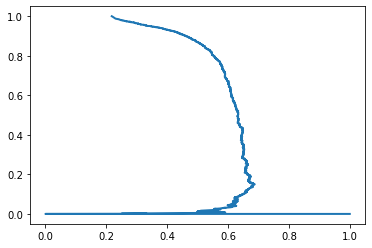

In [74]:
plt.plot(prec, recall, lw=2)

In [75]:
pd.DataFrame({'precision': prec, 'recall': recall}).to_csv('pc_curve_0420_baseline_onecycle_3.csv', index=False)

In [76]:
files = glob.glob('/kaggle/working/train/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/test/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/valid/*/*.png')
for f in files:
    os.remove(f)

In [77]:
acc_his

NameError: name 'acc_his' is not defined

In [78]:
loss_his

NameError: name 'loss_his' is not defined

In [79]:
mtrx

NameError: name 'mtrx' is not defined

In [80]:
os.mkdir('/kaggle/working/models')


In [81]:
# torch.save(model.state_dict(), 'models/weights.h5') #save the model's weights
# model.load_state_dict(torch.load('models/weights.h5')) #load the model's weights

In [82]:
mtrx

NameError: name 'mtrx' is not defined

In [83]:

# for inputs, labels in dataloaders['train']:
#     inputs = inputs.to(device) #convert inputs to cpu or cuda
#     labels = labels.to(device) #convert labels to cpu or cuda


In [84]:
acc_hist = [i.detach().cpu().numpy() for i in acc_his]

NameError: name 'acc_his' is not defined

In [85]:
acc_hist

NameError: name 'acc_hist' is not defined

In [86]:
train_loss, train_acc = [],[]
val_loss, val_acc = [], []
for i in range(40):
    if i%2 ==0:
        val_loss.append(loss_his[i])
        val_acc.append(float(acc_hist[i]))
    else:
        train_loss.append(loss_his[i])
        train_acc.append(float(acc_hist[i]))


NameError: name 'loss_his' is not defined

In [87]:
train_loss

[]

In [88]:
val_loss

[]

In [89]:
train_acc

[]

In [90]:
val_acc

[]